###   Name: Anthony Ayebiahwe
###   Title :  Visualizing Abandoned Vehicles in Philadelphia
###    Data Wrangling Final Project
 
     

In [19]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
# read 311 data request from Open Philly
df=pd.read_csv('C:/Users/Anthony Ayebi/Desktop/public_cases_fc.csv')

In [21]:
# Finding the length of the data row and checking the head for the columns
print("the number rows in df=",len(df))


the number rows in df= 1048575


In [22]:
df.head()

,the_geom,lon,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,the_geom_webmercator,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,service_notice
0,0101000020E6100000E4B3869C48CB52C07395B403AAF4...,-75.176307,111,8997243,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00006B4EB00C73EC5FC1025391455683...,1/30/2015,8/12/2015,3/12/2015,1620 CROATAN PL,NaN,NaN,39.911438,30 Business Days
1,0101000020E61000007D98F71785CD52C0D76474DD67FA...,-75.211248,50,8967080,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,0101000020110F00003456DA773FF05FC1DC4F534BB289...,1/11/2015,8/12/2015,1/19/2015,4439 IONIC ST,19104,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.956295,7 Business Days
2,0101000020E610000054988C9D8FCD52C0A118D5F922FA...,-75.211891,51,8967081,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,0101000020110F00000F4A2C5751F05FC10BBFD0F76589...,1/11/2015,8/12/2015,1/19/2015,229 S 45TH ST,19104,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.954192,7 Business Days
3,0101000020E6100000B8FD971098C952C0EEE5C271AE08...,-75.149906,55,8997258,Closed,NaN,Vacant House or Commercial,SR-LI27,License & Inspections,0101000020110F00009DCD5B5394E95FC18BE9E7C78699...,1/30/2015,8/12/2015,2/26/2015,1986 STERLING ST,NaN,NaN,40.067824,20 Business Days
4,0101000020E61000006794366E14C252C0DDD28B56C505...,-75.032497,58,8997261,Closed,Question Answered,Information Request,SR-IR01,Philly311 Contact Center,0101000020110F0000EC2DD5D6D0DC5FC11E53A6024C96...,1/31/2015,8/12/2015,NaN,3300 DECATUR ST,NaN,NaN,40.045085,None


In [23]:
# Removing all the reported data missing latitude and longitude
df = df.dropna(subset=['lat', 'lon'])

In [25]:
df['Coordinates'] = list(zip(df['lon'], df['lat']))

In [26]:
from shapely.geometry import Point
df['Coordinates'] = df['Coordinates'].apply(Point)

In [27]:
df = gpd.GeoDataFrame(df, geometry='Coordinates', 
                            crs={'init': 'epsg:4326'})

In [28]:
abvehicle = df.loc[df['service_name']=='Abandoned Vehicle']
abvehicle = abvehicle.to_crs(epsg=3857)
print('number of potholes = ', len(abvehicle))

number of potholes =  25556


In [26]:
# Interest is to calculate the number of abandoned vehicles in Philadelphia neighborhoods
#First, let's load zillow neighboorhood data by neighborhood
zillow = gpd.read_file('C:/Users/Anthony Ayebiahwe/Desktop/zillow_neighborhood.geojson')
zillow = zillow.to_crs(epsg=3857)
zillow.head()

,ZillowName,geometry
0,Academy Gardens,POLYGON ((-8348795.676844054 4875297.327437355...
1,Airport,POLYGON ((-8370923.380392455 4850336.405079939...
2,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...
3,Andorra,"POLYGON ((-8373967.120433775 4875663.02380158,..."
4,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...


In [27]:
joined = gpd.sjoin(abvehicle, zillow, op='within', how='left')

In [29]:
totals = joined.groupby('ZillowName').size()
type(totals)

pandas.core.series.Series

In [30]:
totals = totals.to_frame('N').reset_index()
totals.head()

,ZillowName,N
0,Academy Gardens,51
1,Airport,3
2,Allegheny West,273
3,Andorra,4
4,Aston Woodbridge,57


In [31]:
#Merging the total per neighborhood with the geomtry
totals = pd.merge(zillow, totals, on='ZillowName')

In [32]:
# Interactively, let's represent the number of abandoned vehicle across the areas in Philadelphia
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [34]:
#
totals['N_per_area'] = totals['N'] / (totals.geometry.area)

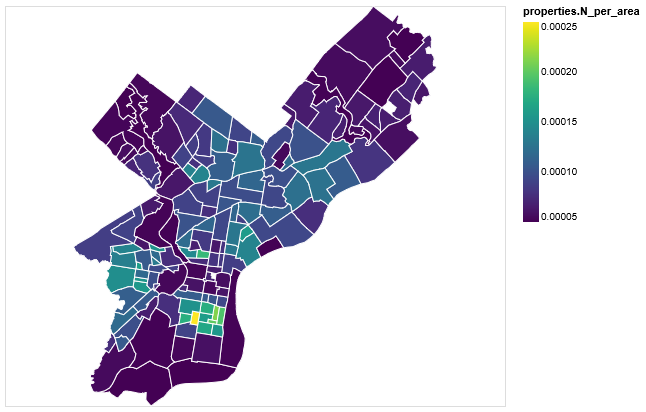

In [35]:
# create an altair data source from a GeoJSON representation
data  = alt.InlineData(values=totals.to_crs(epsg=4326).to_json(),
                       format=alt.DataFormat(property='features',type='json'))

# plot map, where variables are nested within `properties`, 
alt.Chart(data).mark_geoshape(
    stroke='white',
).properties(
    width=500,
    height=400,
    projection={"type":'mercator'},
).encode(
    tooltip=['properties.N_per_area:Q', 'properties.ZillowName:N'],
    color='properties.N_per_area:Q'
)

As can be seen from the chart above, Newbold is the area with more abandoned vehicles

However, I am more interested in identify daily trends of vehicle abandonment in Philadelphia.Hence, I will use Datashader to generate an hourly time-lapse GIF to show the trends of vehicle abandonment in Philadelphia daily.

In [36]:
# Load more packages
import zipfile
import os
import urllib
import dask.dataframe as dd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Greys9, viridis, inferno

C:\Users\Anthony Ayebiahwe\anaconda3\envs\musa-620\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Anthony Ayebiahwe\anaconda3\envs\musa-620\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [45]:
abvehicle.head()

,the_geom,lon,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,the_geom_webmercator,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,service_notice,Coordinates,hours
0,0101000020E6100000EC66674D43CF52C036779195A1FB...,-75.238483,2,8967058,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00001CC20B6635F35FC1CF3B49E90D8B...,2015-01-11 13:45:00,8/12/2015 3:47,2/19/2015 19:00,5915 SUMMER ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.965869,30 Business Days,POINT (-8375509.594467666 4860983.645094826),13
11,0101000020E6100000DA709A364AC652C008780C6E6FFE...,-75.098280,49,8967079,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F000078BDCA8FF7E35FC12CE22081298E...,2015-01-11 17:45:00,8/12/2015 3:47,2/19/2015 19:00,3417 MERCER ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.987776,30 Business Days,POINT (-8359902.246749274 4864166.017632049),17
13,0101000020E6100000E4B3869C48CB52C07395B403AAF4...,-75.176307,111,8997243,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00006B4EB00C73EC5FC1025391455683...,2015-01-30 20:45:00,8/12/2015 3:47,3/12/2015 20:00,1620 CROATAN PL,NaN,NaN,39.911438,30 Business Days,POINT (-8368588.198260884 4853081.086994888),20
40,0101000020E61000000E96FB2EF6CB52C06D82DA3542FF...,-75.186901,198,10871487,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F000023A615E199ED5FC161F08B29138F...,2016-08-04 10:33:00,6/15/2017 15:15,9/19/2016 20:00,3347 RIDGE AVE,NaN,NaN,39.994208,30 Business Days,POINT (-8369767.516946348 4865100.649166198),10
42,0101000020E6100000FA43756B80C252C0FE68D53AB303...,-75.039088,200,8997403,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00005423104588DD5FC140A03EF8FF93...,2015-02-01 12:45:00,8/12/2015 3:47,3/12/2015 20:00,7104 MARSDEN ST,NaN,NaN,40.028907,30 Business Days,POINT (-8353313.079109985 4870143.878822387),12


In [46]:
# change coordinates to Web Mercator (EPSG code 3857)
from datashader.utils import lnglat_to_meters as webm
abvehicle.loc[:, "lon"], abvehicle.loc[:, "lat"], = webm(abvehicle["lon"],abvehicle["lat"])

In [47]:
# extract vehicle abandonment in Philadelphia by hour
abvehicle['requested_datetime'] = pd.to_datetime(abvehicle['requested_datetime'])
abvehicle['hours'] = abvehicle.requested_datetime.dt.hour

In [48]:
PHL = x_range, y_range = ((-8380000,-8340000), (4850000,4890000))
plot_width  = int(500)
plot_height = int(plot_width//1.2)

def create_image(abvehicle, x_range, y_range, w=plot_width, h=plot_height, cmap=viridis):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot positions, coutning number of passengers
    agg = cvs.points(abvehicle, 'lon', 'lat')
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [49]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [50]:
def plot_by_hour(fig, abvehicle, hour):
    
    # trim to the specific hour
    abvehicle= abvehicle.loc[abvehicle['hours']==hour]
    
    # create the datashaded image
    x_range = PHL[0]
    y_range = PHL[1]
    img = create_image(abvehicle, x_range, y_range)
    
    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis('off')
    
    # add a text label for the hour
    ax.text(0.05, 0.9, convert_to_12hour(hour), color='white', 
            fontsize=40, ha='left', transform=ax.transAxes)
    
   
    # draw the figure and return the image
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

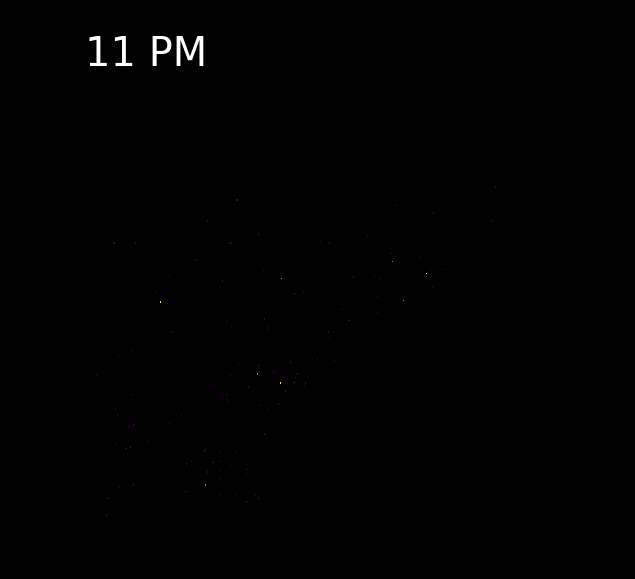

In [51]:
import imageio

# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# save the GIF
hours = range(24)
imageio.mimsave('C:/Users/Anthony Ayebiahwe/Desktop/vehicle_abandonment.gif', [plot_by_hour(fig, abvehicle, hr) for hr in hours], fps=1);

As can be seen from the GIF, majority of the reports for vehicle abandonment occur from 8am until 5pm in Philadelphia.

In [11]:
#Part 2: For this part, I am interested in generating a heatmap of vehicle abandonment in Philadelphia

In [30]:
import folium

In [32]:
# Let represent vehicle abandonment with the color red:
df1 = df[['lat','lon','service_name']]
df1 = df1.dropna()

# Add a column of colors for 311 request that is vehicle abandonment and non-vehicle abandonment
def vehicle_abandonment (row):
    if row['service_name'] == 'Abandoned Vehicle':
        return 'red'
    
    if row['service_name'] != 'Abandoned vehicle':
        return 'orange'

df1['color'] = df1.apply (lambda row: vehicle_abandonment(row), axis=1)

df1.head()

,lat,lon,service_name,color
0,39.911438,-75.176307,Abandoned Vehicle,red
1,39.956295,-75.211248,Graffiti Removal,orange
2,39.954192,-75.211891,Graffiti Removal,orange
3,40.067824,-75.149906,Vacant House or Commercial,orange
4,40.045085,-75.032497,Information Request,orange


In [33]:
m = folium.Map(
    location=[39.91, -75.17],
    zoom_start=11.5,
    tiles="Stamen Terrain"
)

#import pluggins
import folium.plugins
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for i in range(0, len(df1)):
    folium.Marker(
      location=[df1.iloc[i]['lat'],df1.iloc[i]['lon']],
      popup=df1.iloc[i]['service_name'],
      icon=folium.Icon(color=df1.iloc[i]["color"])
   ).add_to(marker_cluster)

In [34]:
#Heatmap of the vehicle abandonment in Philadelphia
from folium.plugins import HeatMap

In [35]:
coordinates = df[['lat', 'lon']].values

m1 = folium.Map(
    location=[39.91, -75.17],
    zoom_start=11.5,
    tiles="Stamen Toner"
)

In [36]:
HeatMap(coordinates).add_to(m1)
m1.save('map.html')
from IPython.display import IFrame
IFrame('map.html', width=500, height=600)

In [37]:
#Download Philadelphia Housing prices
df2=pd.read_csv('C:/Users/anthony ayebi/Desktop/Phila_Price.csv')

In [38]:
df2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,274772,Northeast Dallas,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,1,135800.0,135500.0,134900.0,...,316600,317300,317800,318600,320800,324700,330400,336300,340600,342500
1,192689,Paradise,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,2,119400.0,119400.0,119300.0,...,244200,247600,251400,255000,258100,260500,261900,262600,263400,264100
2,270958,Upper West Side,New York,NY,New York-Newark-Jersey City,New York County,3,299500.0,299700.0,299600.0,...,1391400,1383300,1379600,1372000,1361800,1349700,1336100,1324300,1318800,1319900
3,118208,South Los Angeles,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,4,122700.0,122900.0,123100.0,...,464700,466900,469400,471900,474100,475600,477400,480400,482600,482200
4,270957,Upper East Side,New York,NY,New York-Newark-Jersey City,New York County,5,339400.0,339900.0,340500.0,...,1382900,1366200,1357700,1346800,1328800,1313200,1301400,1288000,1275100,1269300


In [39]:
# Trim housing prices for the city of Philadelphia
df3_phila=df2[df2['CountyName']=='Philadelphia County']
df3_phila.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
165,214232,Oxford Circle,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,166,63600.0,63400.0,63200.0,...,142300,143400,144400,146100,148200,150400,152900,154800,155400,155400
205,214146,Olney,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,206,45800.0,45800.0,45800.0,...,89600,89900,89600,89200,89400,90400,91600,92600,94200,95600
246,274834,West Oak Lane,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,247,54900.0,54900.0,55000.0,...,141700,142000,142600,143700,145000,146800,149200,150900,151100,150600
265,274451,Mayfair,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,266,67800.0,67700.0,67700.0,...,158500,160700,162800,165000,167400,170100,172500,173600,174200,174700
285,403167,Overbrook,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,286,60500.0,60500.0,60600.0,...,140400,141000,140900,141600,143600,146400,149400,151300,152200,153000


In [64]:
#Convert GeoDataFrame to Panda GeoDataFrame 
df4= pd.DataFrame(abvehicle)

In [67]:
#Concatenate the data frame with the abandoned vehicle and housing prices for Philadelphia
Philla=pd.concat([df4.reset_index(drop=True), df3_phila.reset_index(drop=True)], axis=1)

In [68]:
Philla.head()

,the_geom,lon,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,the_geom_webmercator,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,0101000020E6100000E4B3869C48CB52C07395B403AAF4...,-75.176307,111,8997243,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00006B4EB00C73EC5FC1025391455683...,...,142300.0,143400.0,144400.0,146100.0,148200.0,150400.0,152900.0,154800.0,155400.0,155400.0
1,0101000020E61000000E96FB2EF6CB52C06D82DA3542FF...,-75.186901,198,10871487,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F000023A615E199ED5FC161F08B29138F...,...,89600.0,89900.0,89600.0,89200.0,89400.0,90400.0,91600.0,92600.0,94200.0,95600.0
2,0101000020E6100000FA43756B80C252C0FE68D53AB303...,-75.039088,200,8997403,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00005423104588DD5FC140A03EF8FF93...,...,141700.0,142000.0,142600.0,143700.0,145000.0,146800.0,149200.0,150900.0,151100.0,150600.0
3,0101000020E6100000B2B0D09CEFC652C054A4CA498BFE...,-75.108375,165,8997300,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00008ABA4C8210E55FC11C749A62488E...,...,158500.0,160700.0,162800.0,165000.0,167400.0,170100.0,172500.0,173600.0,174200.0,174700.0
4,0101000020E6100000EC66674D43CF52C036779195A1FB...,-75.238483,2,8967058,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,0101000020110F00001CC20B6635F35FC1CF3B49E90D8B...,...,140400.0,141000.0,140900.0,141600.0,143600.0,146400.0,149400.0,151300.0,152200.0,153000.0


Interested in finding out the correlation between Request on abandoned buildings and current housing prices in Philadelphia.

In [71]:
Philla.describe()

,lon,objectid,service_request_id,lat,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
count,25556.000000,2.555600e+04,2.555600e+04,25556.000000,89.000000,89.000000,80.000000,80.000000,80.000000,80.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,-75.143702,9.749680e+05,1.023768e+07,39.999411,395695.269663,2178.764045,74823.750000,74815.000000,74778.750000,74728.750000,...,252856.179775,253931.460674,254866.292135,256547.191011,258888.764045,261247.191011,263661.797753,265429.213483,266433.707865,266828.089888
std,0.306738,9.855497e+05,8.332475e+05,0.073894,238895.161055,1751.619420,26484.962267,26545.685959,26576.989637,26608.622347,...,122966.670424,123221.165349,123630.738624,124260.324329,125071.479052,125846.133586,126852.816919,127532.567322,127445.863680,126971.105329
min,-123.081930,2.000000e+00,8.853724e+06,39.884807,5568.000000,166.000000,29400.000000,29300.000000,29200.000000,29200.000000,...,89300.000000,89900.000000,89600.000000,89200.000000,89400.000000,90400.000000,91600.000000,92600.000000,94200.000000,95600.000000
25%,-75.182032,3.693295e+05,9.338362e+06,39.966627,215211.000000,842.000000,59100.000000,59100.000000,59200.000000,59050.000000,...,180300.000000,181400.000000,181700.000000,182400.000000,183700.000000,185800.000000,187600.000000,188700.000000,187700.000000,186600.000000
50%,-75.148233,6.915740e+05,1.063617e+07,40.002603,271203.000000,1603.000000,70400.000000,70550.000000,70650.000000,70800.000000,...,227600.000000,228000.000000,229400.000000,231100.000000,232700.000000,234400.000000,236200.000000,237200.000000,237600.000000,237600.000000
75%,-75.095060,1.245281e+06,1.093636e+07,40.032954,753805.000000,3213.000000,88100.000000,88150.000000,88200.000000,88300.000000,...,299100.000000,299300.000000,299700.000000,302400.000000,307100.000000,311400.000000,315200.000000,318300.000000,321400.000000,323300.000000
max,-74.962886,6.308974e+06,1.259332e+07,49.282181,753841.000000,7139.000000,184900.000000,185300.000000,185500.000000,185700.000000,...,728900.000000,732000.000000,736800.000000,741700.000000,746000.000000,751000.000000,760200.000000,768500.000000,764800.000000,754000.000000


From the information above, the current average housing price is around $267,000 

In [72]:
print( Philla.corr())

                         lon  objectid  service_request_id       lat  \
lon                 1.000000 -0.002220            0.005605 -0.685754   
objectid           -0.002220  1.000000            0.598743 -0.020176   
service_request_id  0.005605  0.598743            1.000000 -0.009515   
lat                -0.685754 -0.020176           -0.009515  1.000000   
RegionID           -0.147275  0.130310            0.111388  0.175795   
SizeRank           -0.069828  0.039378            0.026073  0.146448   
1996-04             0.000102 -0.160283           -0.122592  0.205353   
1996-05             0.000641 -0.159663           -0.121609  0.205788   
1996-06             0.000956 -0.159093           -0.120597  0.205961   
1996-07             0.001708 -0.158490           -0.119835  0.206680   
1996-08             0.002365 -0.158586           -0.119616  0.207407   
1996-09             0.003415 -0.158331           -0.118967  0.207925   
1996-10             0.004592 -0.158063           -0.118530  0.20

From the above correlation, there is a positive correlation between abandoned vehicle request and the current housing prices. Hence, as the abandoned vehicle requests go up, the housing prices in Philadelphia are more likely to go up.